In [ ]:
!pip install torch transformers
!rm -f wassa2023-shared-task.tar.gz
!wget 'https://raw.githubusercontent.com/00ber/ml-projects/main/data/wassa2023-shared-task.tar.gz'
!tar -xf wassa2023-shared-task.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.0 MB/s eta 0:00:00
--2023-05-06 17:58:14--  https://raw.githubusercontent.com/00ber/ml-projects/main/data/wassa2023-shared-task.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4321231 (4.1M) [application/octet-stream]
Saving to: ‘wassa2023-shared-task.tar.gz’

wassa2023-shared-ta 100%[===================>]   4.12M  --.-KB/s    in 0.07s   

2023-05-06 17:58:14 (58.6 MB/s) - ‘wassa2023-shared-task.tar.gz’ saved [4321231/4321231]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

class OrdinalLabelEncoder:
    def get_feature_names_out(self, prefix="X"):
      return list(map(lambda x: f"{prefix}_{x}", self.classes_))
    
    def fit(self, y):
      self.classes_ = sorted(list(set(y)))
      self.sorter = np.argsort(self.classes_)
      
    def fit_transform(self, y):
        y = y.to_numpy()
        self.classes_ = sorted(list(set(y.reshape(-1))))
        self.sorter = np.argsort(self.classes_)
        idx = self.sorter[np.searchsorted(self.classes_, y, sorter=self.sorter)]
        ordinal_labels = np.zeros((y.shape[0], len(self.classes_)))

        for row, i in enumerate(idx):
          ordinal_labels[row,:i[0]+1] = 1
        return ordinal_labels

    def transform(self, y):
        idx = self.sorter[np.searchsorted(self.classes_, y, sorter=self.sorter)]
        ordinal_labels = np.zeros((y.shape[0], len(self.classes_)), dtype="int32")

        for row, i in enumerate(idx):
          ordinal_labels[row][:i[0]+1] = 1
        ordinal_labels = ordinal_labels.astype("int32")
        return ordinal_labels

    def inverse_transform(self, y_ordinal):
        idx = y_ordinal.sum(axis=1, keepdims=True)
        idx = idx.numpy()
        idx = idx.astype("int32")
        classes = np.array(self.classes_)
        return classes[idx - 1]


class Encoder:
  def __init__(self, enc_type=None):
    self.enc_type = enc_type
    if enc_type is None:
      self.enc = None
    elif enc_type == "ohe":
      self.enc = OneHotEncoder()
    elif enc_type == "label":
      self.enc = LabelEncoder()
    elif enc_type == "ordinal":
      self.enc = OrdinalLabelEncoder()

  def fit(self, df, target_column):
    if self.enc_type is None:
      self.target_column = target_column
      self.classes = []
      self.num_classes = 0 
    elif self.enc_type == "ohe":
      self.target_column = target_column
      self.enc.fit(df[[target_column]])
      self.classes = self.enc.categories_[0]
      self.num_classes = len(self.classes)
    elif self.enc_type == "label":
      self.target_column = target_column
      self.enc.fit(df[target_column])
      self.classes = self.enc.classes_
      self.num_classes = len(self.classes)
    elif self.enc_type == "ordinal":
      self.target_column = target_column
      self.enc.fit(df[target_column])
      self.classes = self.enc.classes_
      self.num_classes = len(self.classes)
    else:
      raise Exception(f"Unknown encoding type {self.enc_type}")

  def transform(self, df):
    if self.enc_type is None:
      return df[self.target_column]
    elif self.enc_type == "ohe":
      return self.enc.transform(df[[self.target_column]]).toarray() 
    elif self.enc_type == "label":
      return self.enc.transform(df[self.target_column])
    elif self.enc_type == "ordinal":
      return self.enc.transform(df[[self.target_column]])
    else:
      raise Exception(f"Unknown encoding type {self.enc_type}")

  def inverse_transform(self, val):
    if self.enc_type in ["ohe", "label", "ordinal"]:
      return self.enc.inverse_transform(val) 
    else:
      raise Exception(f"Cannot inverse transform with encoding type {self.enc_type}")

  def get_column_names(self):
    if self.enc_type == "ohe":
      return self.enc.get_feature_names_out()
    if self.enc_type == "ordinal":
      return self.enc.get_feature_names_out(prefix=self.target_column)
    else:
      return np.array([self.target_column])
    
class Preprocessor:
  def __init__(self, path, tokenizer, text_col, encoder, max_token_len=512):
    self.path = path
    self.tokenizer = tokenizer
    self.text_col = text_col
    self.max_token_len = max_token_len 
    self.encoder = encoder
    self._prepare_data()


  def _prepare_data(self):
    self.df = pd.read_table(self.path["convs"])
    if "conv_labels" in self.path:
      conv_labels_df = pd.read_table(self.path["conv_labels"], names=["EmotionalPolarity", "Emotion", "Empathy"])
      self.df = pd.concat([self.df, conv_labels_df], axis=1)
    
    def tokenize(target_col):
      def _tokenize(row):
        text = row[target_col]
        tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_tensors="pt",
            truncation=True,
            max_length=self.max_token_len,
            padding="max_length",
            return_attention_mask=True
        )
        return tokens["input_ids"].numpy(), tokens["attention_mask"].numpy()
      return _tokenize

    self.tokenized_input = self.df.apply(tokenize(self.text_col), axis=1)
    self.labels = self.encoder.transform(self.df)

  def get_tokenized_data(self):
    tokenized_series = self.tokenized_input.apply(pd.Series)
    input_ids = tokenized_series[0].to_numpy().reshape(-1, 1)
    attention_mask = tokenized_series[1].to_numpy().reshape(-1, 1)
    labels = self.labels
    return input_ids, attention_mask, labels

In [ ]:
import pandas as pd 
from transformers import AutoTokenizer

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_path = {
    "convs": "/content/WASSA23_conv_level_with_labels_train.tsv",
    "essays": "/content/WASSA23_essay_level_with_labels_train.tsv",
    "articles": "/content/articles_adobe_AMT.csv"
}
val_path = {
    "convs": "/content/WASSA23_conv_level_dev.tsv",
    "conv_labels": "/content/goldstandard_CONV_dev.tsv",
    "essays": "/content/WASSA23_essay_level_dev.tsv",
    "essay_labels": "/content/goldstandard_dev.tsv",
    "articles": "/content/articles_adobe_AMT.csv"
}

max_token_len = 96
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
label_col = "Empathy"
encoder = Encoder("label")
_df = pd.read_table("/content/WASSA23_conv_level_with_labels_train.tsv")
encoder.fit(_df, label_col)

preprocessor_train = Preprocessor(train_path, tokenizer, "text", encoder, max_token_len=max_token_len)
preprocessor_val = Preprocessor(val_path, tokenizer, "text", encoder, max_token_len=max_token_len)

In [ ]:
from tensorflow.python.ops.numpy_ops import ndarray
from tensorflow.python.ops.gen_logging_ops import Print
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset


class ConversationDataset(Dataset):
  def __init__(self, input_ids, attention_mask, labels):
    self.input_ids = input_ids
    self.attention_mask = attention_mask 
    if len(labels.shape) > 1:
      self.labels = torch.FloatTensor(labels)
    else:
      self.labels = labels if isinstance(labels, np.ndarray) else torch.tensor(labels.to_numpy()).float() 
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    input_ids = torch.tensor(self.input_ids[idx][0][0])
    attention_mask = torch.tensor(self.attention_mask[idx][0][0])
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": self.labels[idx]
    }

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_input, train_attn_mask, train_labels = preprocessor_train.get_tokenized_data()
val_input, val_attn_mask, val_labels = preprocessor_val.get_tokenized_data()

train_ds = ConversationDataset(train_input, train_attn_mask, train_labels)
val_ds = ConversationDataset(val_input, val_attn_mask, val_labels)


val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False
)

In [ ]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers import AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput


class CustomClassificationHead(nn.Module):
    def __init__(self, hidden_size, hidden_layers_to_use, num_labels, classifier_dropout):
        super().__init__()
        self.hidden_size = hidden_size 
        self.num_labels = num_labels
        self.classifier_dropout = classifier_dropout
        self.hidden_layers_to_use = hidden_layers_to_use

        self.dense = nn.Linear(hidden_size * hidden_layers_to_use, hidden_size)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    def forward(self, hidden_states, **kwargs):
        hidden_state_cls_vectors = []
        for i in range(1, self.hidden_layers_to_use + 1):
          hidden_state_cls_vectors.append(hidden_states[-1 * i][:, 0, :])
        x = torch.cat(hidden_state_cls_vectors, dim=1)
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels, lstm_cells=12, lstm_stack=1, lstm_bidirectional=True, lstm_dropout=0.1):
        super().__init__()
        self.model_name = model_name 
        self.num_labels = num_labels
        self.lstm_cells = lstm_cells
        self.lstm_stack = lstm_stack
        self.lstm_bidirectional = lstm_bidirectional
        self.lstm_dropout = lstm_dropout
        self.pretrained = AutoModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(self.pretrained.config.hidden_size, lstm_cells, lstm_stack, batch_first=True, bidirectional=lstm_bidirectional, dropout=lstm_dropout)
        self.dropout = nn.Dropout(lstm_dropout)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(lstm_cells * 2, num_labels)

    def forward(self,input_ids=None, attention_mask=None,labels=None):
        outputs = self.pretrained(input_ids=input_ids, attention_mask=attention_mask)
        # out = outputs.last_hidden_state[:, 0, :]
        _, (hidden, _) = self.lstm(outputs.last_hidden_state)
        out = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        out = self.relu(self.dropout(out))  
        logits = self.classifier(out)

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            loss_fct = CrossEntropyLoss(label_smoothing=0.1)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            # if self.config.problem_type is None:
            #     if self.num_labels == 1:
            #         self.config.problem_type = "regression"
            #     elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
            #         self.config.problem_type = "single_label_classification"
            #     else:
            #         self.config.problem_type = "multi_label_classification"

            # if self.config.problem_type == "regression":
            #     loss_fct = MSELoss()
            #     if self.num_labels == 1:
            #         loss = loss_fct(logits.squeeze(), labels.squeeze())
            #     else:
            #         loss = loss_fct(logits, labels)
            # elif self.config.problem_type == "single_label_classification":
            #     loss_fct = CrossEntropyLoss()
            #     loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            # elif self.config.problem_type == "multi_label_classification":
            #     loss_fct = BCEWithLogitsLoss()
            #     loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



In [ ]:
model = CustomClassifier(
    model_name, 
    num_labels=encoder.num_classes,
    lstm_cells=12,
    lstm_stack=1,
    lstm_bidirectional=True, 
    lstm_dropout=0.2
).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but l

In [ ]:
from transformers import TrainingArguments
import numpy as np

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/MSML-641-empathy/models/roberta-lstm-empathy/',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    learning_rate=1e-5,
    label_smoothing_factor=0.1,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=300,
    logging_steps=300,
    save_strategy="epoch",
    save_total_limit=1
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
300,2.708600,2.669830
600,2.641700,2.629938
900,2.592800,2.565517
1200,2.564000,2.559016
1500,2.553100,2.539561
1800,2.539200,2.536136
2100,2.534600,2.529781
2400,2.520500,2.535101
2700,2.509100,2.522185
3000,2.524300,2.519941


TrainOutput(global_step=3291, training_loss=2.563996149536615, metrics={'train_runtime': 669.0496, 'train_samples_per_second': 39.351, 'train_steps_per_second': 4.919, 'total_flos': 0.0, 'train_loss': 2.563996149536615, 'epoch': 3.0})

In [ ]:
# 900	2.393300	2.357900

from tqdm.auto import tqdm

predictions = np.array([])
with torch.no_grad():
    model.eval()
    val_loop = tqdm(val_dl)
    for idx, val_batch in enumerate(val_loop):
      input_ids = val_batch["input_ids"].to(device)
      attention_mask = val_batch["attention_mask"].to(device)
      labels = val_batch["labels"].to(device)
      output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      pr = torch.sigmoid(output.logits)
      pr_idx = pr.argmax(axis=-1)
      labels = encoder.classes[pr_idx.cpu()]
      predictions = np.concatenate([predictions, labels], axis=0)

  0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
ohe = OneHotEncoder()
_df = pd.read_table("/content/WASSA23_conv_level_with_labels_train.tsv")
ohe.fit(_df[[label_col]])
num_classes = len(ohe.categories_[0])

predictions_tr = pd.DataFrame(predictions, columns=[label_col])

_transformed = ohe.transform(predictions_tr[[label_col]])
_ohe_df = pd.DataFrame(_transformed.toarray(), columns=ohe.get_feature_names_out())
predictions_tr = pd.concat([predictions_tr, _ohe_df], axis=1).drop([label_col], axis=1)
final_pr = predictions_tr.to_numpy()

val_data = pd.read_table('/content/goldstandard_CONV_dev.tsv', names=["EmotionalPolarity", "Emotion", "Empathy"])
transformed = ohe.transform(val_data[[label_col]]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names_out())
val_data = pd.concat([val_data, ohe_df], axis=1).drop(["Empathy", "EmotionalPolarity", "Emotion"], axis=1)
labels = val_data.to_numpy()

final_pr.shape == labels.shape


True

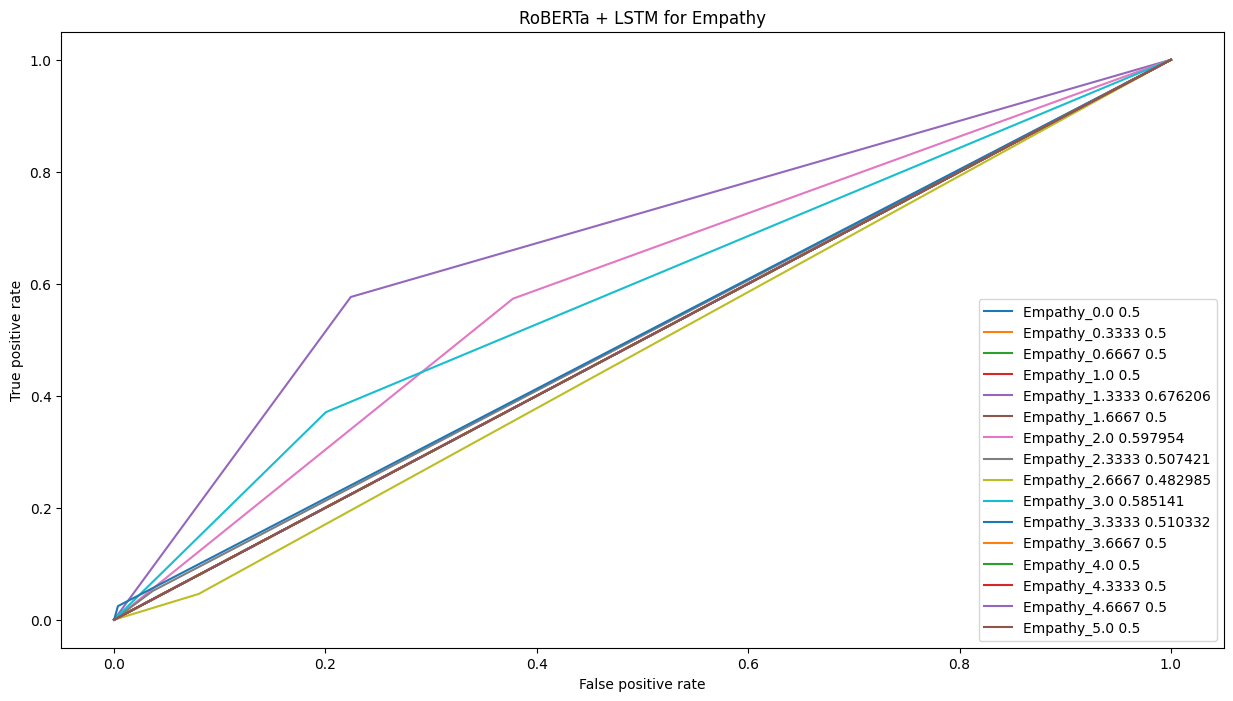

In [ ]:
# Plot
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
for i, label in enumerate(ohe.get_feature_names_out()):
  fpr, tpr, _ = metrics.roc_curve(
      labels[:,i].astype(float), final_pr[:,i]
  )
  auc = metrics.roc_auc_score(
      labels[:,i].astype(float), final_pr[:,i]
  )
  plt.plot(fpr, tpr, label="%s %g" %(label, auc))
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.legend(loc="lower right")
  plt.title("RoBERTa + LSTM for Empathy")

In [ ]:
import gc 
gc.collect()

9867